# Notebook for testing the scoring pipeline on a handful of PDBs from Rocklin et al, 2017, Science

## Import `Python` modules

In [1]:
import os
import sys
sys.path.append('scripts/')
import design_utils

import pandas
import scipy.stats
import numpy
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

resultsdir = 'results/test_designs/'
if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)

## Compute the scores

In [2]:
# Define inputs
pdb_dir = 'scripts/test_designs/'
jugdir = os.path.join(resultsdir, 'jugdir')
sbatch_file_name = os.path.join(resultsdir, 'run.sbatch')

# Assemble the Jug command
cmd = ' '.join([
    'jug',
    'execute',
    '--jugdir {0}'.format(jugdir),
    'scripts/score_designs.py',
    pdb_dir,
    resultsdir
])
cmd = 'source activate 2017_topology_mining\n' + \
    cmd

print("Will use the command:")
print(cmd)

# Write an sbatch file to carry out the command
design_utils.WriteSbatchFile(
    sbatch_file_name,
    command=cmd,
    queue_type='long',
    memory='4g',
    array='1-5'
)

! sbatch {sbatch_file_name}

Will use the command:
source activate 2017_topology_mining
jug execute --jugdir results/test_designs/jugdir scripts/score_designs.py scripts/test_designs/ results/test_designs/
Submitted batch job 5728505


Read in the scores.

In [3]:
out_file_name = os.path.join(resultsdir, 'scores.csv')
#out_file_name = 'results/Rocklin_2017_Science/scores.csv'
test_scores = pandas.read_csv(out_file_name)
test_scores.set_index('Unnamed: 0', inplace=True)
test_scores['PDB_name'] = test_scores.index.map(lambda x: os.path.basename(x))
test_scores.set_index('PDB_name', inplace=True)
test_scores

,AlaCount,T1_absq,T1_netq,Tend_absq,Tend_netq,Tminus1_absq,Tminus1_netq,abego_res_profile,abego_res_profile_penalty,avg_all_frags,...,surface_freq_S,surface_freq_T,surface_freq_V,surface_freq_W,surface_freq_Y,total_score,tryp_cut_sites,two_core_each,worst6frags,worstfrag
PDB_name,,,,,,,,,,,,,,,,,,,,,
EHEE_rd4_0652.pdb,3.0,2,-2,4,4,2,2,0.264624,-0.038460,1.473679,...,0.000000,0.120000,0.000000,0.000000,0.0,-100.753796,8,0.500000,2.9480,0.6266
EHEE_rd4_0594.pdb,2.0,2,-2,3,1,1,-1,0.293818,-0.034234,1.397094,...,0.038462,0.000000,0.076923,0.000000,0.0,-127.686036,6,0.500000,3.1512,0.6533
HHH_rd4_0898.pdb,1.0,7,-3,13,7,6,4,0.243004,-0.038306,0.732443,...,0.083333,0.000000,0.000000,0.000000,0.0,-125.769301,11,0.666667,1.7725,0.3791
EHEE_rd4_0497.pdb,3.0,2,-2,3,3,1,1,0.275143,-0.036151,1.706820,...,0.037037,0.037037,0.074074,0.037037,0.0,-124.320025,5,0.250000,3.7192,0.7116
HEEH_rd4_0544.pdb,0.0,5,-5,7,7,2,2,0.225042,-0.047911,1.462915,...,0.083333,0.166667,0.000000,0.000000,0.0,-109.912345,8,0.750000,5.2529,1.1765
HHH_rd4_0593.pdb,2.0,8,-6,13,9,5,3,0.258947,-0.010049,0.779351,...,0.080000,0.000000,0.000000,0.000000,0.0,-129.056679,12,1.000000,1.4651,0.2630
EHEE_rd4_0964.pdb,5.0,2,-2,4,2,2,0,0.296014,-0.042173,1.694705,...,0.000000,0.076923,0.000000,0.000000,0.0,-114.160828,5,0.500000,3.0921,0.6038
EEHEE_rd4_0872.pdb,4.0,2,-2,4,4,2,2,0.320480,-0.037226,1.491606,...,0.038462,0.153846,0.038462,0.000000,0.0,-130.809781,5,0.400000,2.9393,0.6390
HEEH_rd4_0428.pdb,0.0,3,-3,9,5,6,2,0.218138,-0.037613,1.414739,...,0.045455,0.181818,0.000000,0.000000,0.0,-100.003807,9,0.750000,3.9295,1.0075


## Compare the computed scores with the expected scores from Rocklin et al.

First, I read in scores for these structures taken from the Rocklin et al. study.

In [4]:
rocklin_scores_f = 'scripts/expected_results_for_test_designs.sc'
rocklin_scores = pandas.read_csv(rocklin_scores_f, sep='\t')
rocklin_scores.set_index('description', inplace=True)
del rocklin_scores['SCORE:'] # non-informative line, is 'SCORE:' in all entries
rocklin_scores

,total_score,AlaCount,hbond_lr_bb_per_res,buried_minus_exposed,buried_np,buried_over_exposed,cavity_volume,contact_all,degree,dslf_fa13,...,nearest_chymo_cut_to_Cterm,nearest_tryp_cut_to_Nterm,nearest_tryp_cut_to_Cterm,nearest_tryp_cut_to_term,nearest_chymo_cut_to_term,linear_reg_pred,logistic_reg_pred,gb_reg_pred,logistic_alltop_pred,sequence
description,,,,,,,,,,,,,,,,,,,,,
EEHEE_rd4_0017.pdb,-160.805,4.0,-0.351,3620.422,5344.211,3.100,0.000,172.0,9.930,0.0,...,9,11,16,11,9,1.357650,1.149329,0.959308,0.970023,AEVHVNGVTYKFNNPEEAVKFALELAKKLGMQIEFHGEQIHVE
EEHEE_rd4_0011.pdb,-162.629,4.0,-0.388,3432.576,5231.788,2.908,0.000,157.0,9.791,0.0,...,9,20,12,12,9,1.409006,1.160602,0.973295,0.947713,ATVHVNGVQYDFDNPEEAVKFALKVAKKLNLRIEFHGNTIHIE
EEHEE_rd4_0009.pdb,-157.397,3.0,-0.369,3494.380,5325.690,2.908,0.000,159.0,9.977,0.0,...,9,20,1,1,9,1.339441,1.242149,0.973760,0.955733,VTVHVGNVTYHFNNPEEAVKFALEMAKKLNLEVRFHGNTIKVK
EEHEE_rd4_0012.pdb,-156.772,3.0,-0.380,3483.933,5277.466,2.942,0.000,176.0,9.744,0.0,...,9,20,3,3,9,1.381880,1.175732,0.971164,0.969101,ITIDVNGVTYHFNNPEEAYKFAVKIAKDLNLRIEFHGNTVKIE
EEHEE_rd4_0019.pdb,-153.295,2.0,-0.366,3438.363,5277.682,2.869,0.000,163.0,9.837,0.0,...,9,20,5,5,8,1.273464,1.205246,0.954964,0.943909,TQVHVGGYTYHFNNPEEVLKFALEMARKLNLEVRFHGDRVEIH
EEHEE_rd4_0002.pdb,-161.024,3.0,-0.374,3606.811,5374.905,3.040,0.000,184.0,9.651,0.0,...,9,20,12,12,9,1.513455,1.296829,0.989553,0.983351,VQVHIGNVTYHFDNPEEAYKFAVKMARKLNLRIEFHGNQIHVE
EEHEE_rd4_0006.pdb,-155.610,3.0,-0.392,3333.580,5166.290,2.819,0.000,153.0,9.884,0.0,...,23,11,12,11,10,1.381890,1.269635,0.947519,0.944160,TTVHINGVEYRFDNPEEALRFALEMAKKLNLRVEVHGETIHVE
EEHEE_rd4_0014.pdb,-152.475,2.0,-0.402,3478.815,5302.408,2.908,0.000,158.0,9.558,0.0,...,4,20,3,3,4,1.348901,1.191299,0.948313,0.934837,ITVHVGNVTYHFDTPEEALKFVLKVARSLNLRLEVHGNTFRIE
EEHEE_rd4_0020.pdb,-156.307,4.0,-0.338,3428.624,5272.812,2.859,0.000,156.0,10.116,0.0,...,4,20,8,8,4,1.299726,1.172100,0.951232,0.907181,ATVHVNGYTYHFDKPEQAYKFALKVAQELGLQMHVKDGEFHVE


In [5]:
# Get an ordered list of design PDB file names to compare
pdbs = list(test_scores.index.values)
#pdbs = list(rocklin_scores.index.values)

# Compute the correlation between our scores and the Rocklin scores for each design
corr_d = {}
corr_cutoff = 0.95
metrics_below_corr_cutoff = []
metrics_not_in_rocklin_scores = []
metrics_with_corr_NaN = []
ignore_metrics = ['sequence', 'description', 'dssp']
for metric in test_scores:
    
    # Skip over certain non-quantitative metrics
    if metric in ignore_metrics:
        continue
    
    # Make sure the Rocklin data has the metric
    if metric not in rocklin_scores:
        metrics_not_in_rocklin_scores.append(metric)
        continue
    
    # Correlate our score and the Rocklin score and store
    # in a dictionary. If R = 'NaN', don't store in dict
    (r,p) = scipy.stats.pearsonr(test_scores.loc[pdbs][metric],
                                 rocklin_scores.loc[pdbs][metric])
    if numpy.isnan(r):
        metrics_with_corr_NaN.append(metric)
        continue
    assert metric not in corr_d
    corr_d[metric] = {'Pearson_R':r}
    if r < corr_cutoff:
        metrics_below_corr_cutoff.append(metric)

# Show results
print("Compared the scores from {0} metrics on {1} designs".format(
                                                    len(corr_d),
                                                    len(pdbs)))
print("\n{0} metrics had R > {1}".format(
                                len(corr_d)-len(metrics_below_corr_cutoff),
                                corr_cutoff))
print("\n{0} metrics had R < {1}. They are: {2}".format(
                                len(metrics_below_corr_cutoff),
                                corr_cutoff,
                                ', '.join(metrics_below_corr_cutoff)))
print("\n{0} metrics had R = nan. They are: {1}".format(
                                len(metrics_with_corr_NaN),
                                ', '.join(metrics_with_corr_NaN)))
print("\n{0} metrics were not in the Rocklin scores: {1}".format(
                                len(metrics_not_in_rocklin_scores),
                                ', '.join(metrics_not_in_rocklin_scores)))

# Show a dataframe of each metric and its correlation coefficients
corr_df = pandas.DataFrame.from_dict(corr_d, orient="index")
corr_df

/software/conda/envs/pyrosetta/lib/python3.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Compared the scores from 91 metrics on 10 designs

85 metrics had R > 0.95

6 metrics had R < 0.95. They are: hbond_sc, net_atr_net_sol_per_res, pack, ref, score_per_res, total_score

2 metrics had R = nan. They are: dslf_fa13, ss_contributes_core

581 metrics were not in the Rocklin scores: avg_all_frags_in_E, avg_all_frags_in_H, avg_all_frags_in_L, avg_all_frags_per_site, bb, boundary_bools, boundary_freq_A, boundary_freq_C, boundary_freq_D, boundary_freq_E, boundary_freq_F, boundary_freq_G, boundary_freq_H, boundary_freq_I, boundary_freq_K, boundary_freq_L, boundary_freq_M, boundary_freq_N, boundary_freq_P, boundary_freq_Q, boundary_freq_R, boundary_freq_S, boundary_freq_T, boundary_freq_V, boundary_freq_W, boundary_freq_Y, buns_bb_heavy, buns_nonheavy, buns_sc_heavy, buried_hbonds_info, buried_npsa, buried_npsa_FAMILYVW, buried_npsa_FAMILYVW_boundary, buried_npsa_FAMILYVW_core, buried_npsa_FAMILYVW_surface, buried_npsa_boundary, buried_npsa_core, buried_npsa_surface, buried_psa, bu

,Pearson_R
AlaCount,1.000000
T1_absq,1.000000
T1_netq,1.000000
Tend_absq,1.000000
Tend_netq,1.000000
Tminus1_absq,1.000000
Tminus1_netq,1.000000
abego_res_profile,1.000000
abego_res_profile_penalty,1.000000
avg_all_frags,1.000000


Show correlation plots for each metric

/software/conda/envs/pyrosetta/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/software/conda/envs/pyrosetta/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
/software/conda/envs/pyrosetta/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0


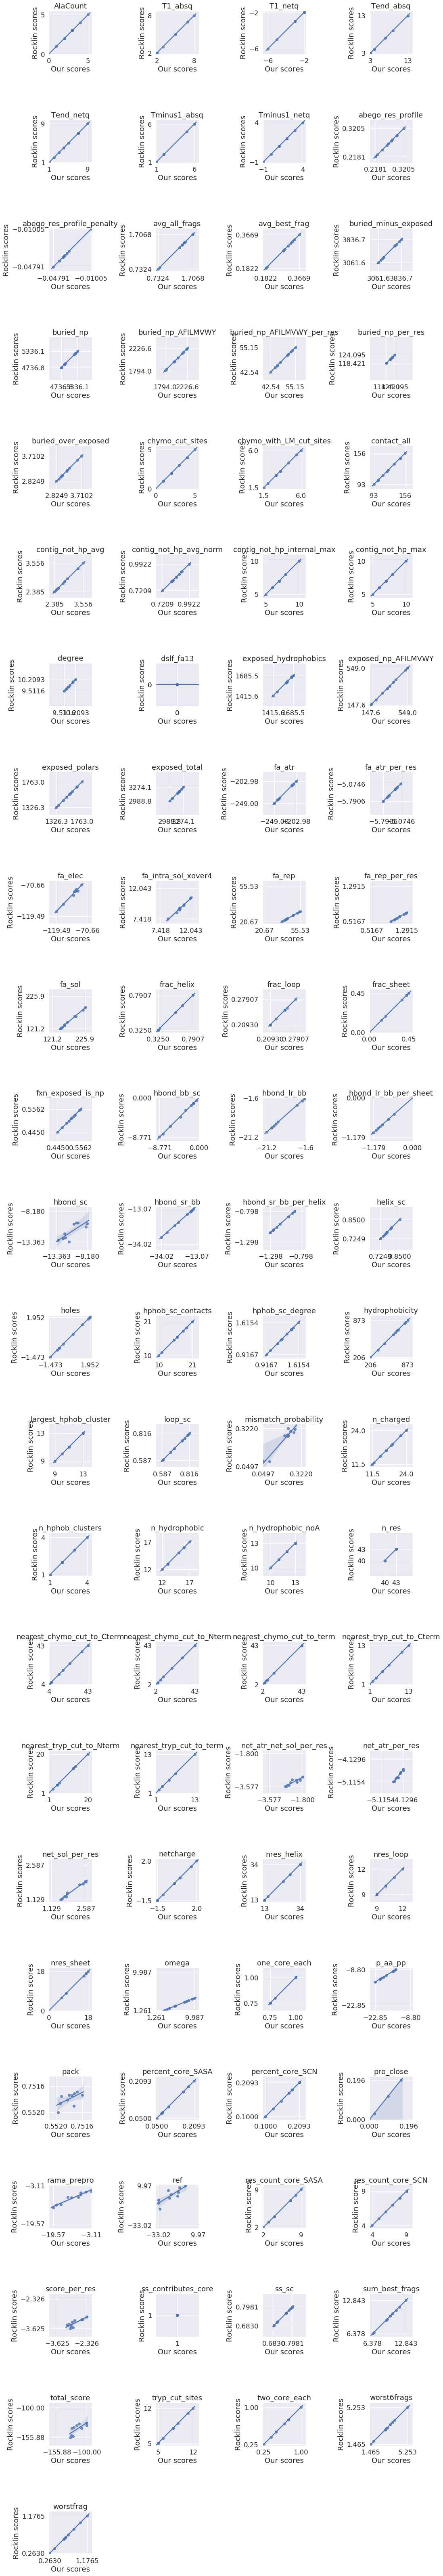

In [6]:
if True:
    metrics_to_plot = sorted(list(corr_d.keys()) + metrics_with_corr_NaN)
    nsubplots = len(metrics_to_plot)
    ncols = 4.0
    nrows = math.ceil(nsubplots/ncols)

    sns.set(font_scale=1.5)
    fig = plt.figure(figsize=[15,(7.5/2)*nrows])
    for (i, metric) in enumerate(metrics_to_plot, 1):
        ax = fig.add_subplot(nrows, ncols, i)
        xs = test_scores.loc[pdbs][metric]
        ys = rocklin_scores.loc[pdbs][metric]
        sns.regplot(xs, ys, ax=ax)
        min_val = min(list(xs) + list(ys))
        max_val = max(list(xs) + list(ys))
        ticks = [min_val, max_val]
        lims = [min_val-abs(0.1*min_val), max_val+abs(0.1*max_val)]
        ax.axis('square')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xlabel('Our scores')
        ax.set_ylabel('Rocklin scores')
        ax.set_title(metric)
        #ax.text(0, 1, "R = {0}".format(round(corr_d[metric]['Pearson_R'], 2)))
    plt.tight_layout()

## Summarize the metrics that are still missing

In [7]:
our_metrics = set(test_scores)
rocklin_metrics = set(rocklin_scores)
rocklin_xml_metrics = set([
            "res_count_core_SCN",
           "res_count_core_SASA",
            "percent_core_SCN",
           "percent_core_SASA",
            "contact_all",
            "contact_core_SCN",
            "contact_core_SASA",
            "degree",
            "entropy",
            "dslf_quality_check",
            "mean_dslf",
            "cavity_volume",
            "ss_sc",
            "helix_sc",
            "loop_sc",
            "exposed_total",
            "exposed_hydrophobics",
            "exposed_polars",
            "fxn_exposed_is_np",
            "holes",
            "bb",
            "buried_np",
            "buried_over_exposed",
            "buried_minus_exposed",
            "pack",
            "mismatch_probability",
            "unsat_hbond",
            "unsat_hbond2",
            "one_core_each",
            "two_core_each",
            "ss_contributes_core",
            "AlaCount"
])


important_rocklin_metrics = set([
            'avg_all_frags',
            'net_atr_net_sol_per_res',
            'n_charged',
            'buried_np_AFILMVWY_per_res',
            'avg_best_frag',
            'fa_atr_per_res',
            'exposed_polars',
            'unsat_hbond',
            'mismatch_probability',
            'hbond_lr_bb',
            'exposed_np_AFILMVWY',
            'fa_rep_per_res',
            'degree',
            'p_aa_pp',
            'netcharge',
            'worstfrag',
            'frac_sheet',
            'buried_np_per_res',
            'abego_res_profile_penalty',
            'hbond_sc',
            'holes',
            'cavity_volume',
            'score_per_res',
            'hydrophobicity',
            'hbond_bb_sc',
            'ss_sc',
            'contig_not_hp_max',
            'contact_all',
            'omega',
            'exposed_hydrophobics',
            'contig_not_hp_avg' 
])

#XML_metrics_in_common = set.intersection(our_metrics, rocklin_xml_metrics)
#print("We have implemented {0} custom metrics from the Rocklin et al XML:".format(len(XML_metrics_in_common)))
#print(list(XML_metrics_in_common))

print("We have implemented {0} metrics".format(len(our_metrics)))
print(our_metrics)

missing_XML_metrics = rocklin_xml_metrics.difference(our_metrics)
print("\nWe are missing {0} custom metrics from the Rocklin et al. XML:".format(len(missing_XML_metrics)))
print(list(missing_XML_metrics))

missing_important_metrics = important_rocklin_metrics.difference(our_metrics)
print("\nWe are missing {0} of the most important metrics from Rocklin et al.:".format(
        len(missing_important_metrics)))
print(list(missing_important_metrics))

all_missing_metrics = rocklin_metrics.difference(our_metrics)
print("\nIn total, we are missing {0} metrics from Rocklin et al.".format(len(all_missing_metrics)))
print(list(all_missing_metrics))

We have implemented 677 metrics
{'percent_core_SASA', 'core_freq_C', 'freq_ML', 'helices_freq_E', 'freq_VE', 'helices_freq_R', 'exposed_total', 'strands_freq_Y', 'fa_dun_semi', 'freq_IE', 'freq_YP', 'freq_CL', 'freq_IW', 'surface_freq_Q', 'freq_YG', 'buried_npsa_surface', 'freq_TR', 'freq_L', 'freq_SP', 'freq_TL', 'freq_FL', 'fa_dun_dev', 'freq_M', 'freq_RP', 'freq_DK', 'freq_ET', 'core_freq_F', 'freq_CW', 'freq_MW', 'freq_PT', 'surface_freq_H', 'helices_freq_S', 'freq_DN', 'freq_LR', 'rama_prepro', 'percent_polar_core_stringent', 'freq_GN', 'freq_RA', 'avg_all_frags_in_L', 'net_atr_per_res', 'freq_RQ', 'freq_YH', 'freq_SR', 'freq_P', 'freq_MP', 'freq_VD', 'nres_sheet', 'freq_WP', 'freq_HR', 'surface_freq_T', 'freq_EY', 'freq_H', 'freq_MH', 'freq_NL', 'strands_freq_C', 'freq_PL', 'freq_VM', 'freq_WH', 'freq_DR', 'nearest_chymo_cut_to_Cterm', 'boundary_freq_T', 'contig_not_hp_internal_max', 'freq_WR', 'n_buried_hbonds', 'freq_AC', 'helices_freq_L', 'strands_freq_D', 'core_freq_T', 'freq